<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_Atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieves HAFS-A data from AWS along a storm's track using files generated by getStormTrack.ipynb.

Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal

In [ ]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

User parameters

In [ ]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/ColabNotebooks/{name}"
trackType = "major"

Open TC Data

In [ ]:
tc = pd.read_csv(filepath + "/hurdat2_" + name + "_" + trackType + ".csv")

In [ ]:
tc

Retrieve HAFS-A Atmospheric Data

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = tc.time[0]
startDate, startTime = start.split(" ")
startYear, startMonth, startDay = startDate.split("-")
startHour, startMinute, startSecond = startTime.split(":")

end = tc.time[len(tc)-1]
endDT = dt.strptime(end, dateFormat)
endDate, endTime = end.split(" ")
endYear, endMonth, endDay = endDate.split("-")
endHour, endMinute, endSecond = endTime.split(":")

Determine times needed

In [ ]:
bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

fcastTimes = {} #Key: initiation, item: Forecast Hour

for row in tc.iloc:
  fcastTimes[row.time] = []
  rowTime = dt.strptime(row.time, dateFormat)
  if rowTime.hour % 6 != 0 or rowTime.minute != 0: continue #Skip any lines that don't have a HAFS forecast at the same time

  for fhour in range(0, 127, 3):
    valid = rowTime + pd.Timedelta(hours=fhour)
    if valid <= endDT:
      fcastTimes[row.time].append(fhour)

Get MSLP data from HAFS-A output.

In [ ]:
stormFiles = []
stormMSLP = {} #Stores pressure along TC track for all forecast hours

for init, fhourList in fcastTimes.items():
  for fhour in fhourList:

    fhour = str(fhour)
    while len(fhour) < 3: fhour = "0" + fhour

    initDate, initTime = init.split(" ")
    initYear, initMonth, initDay = initDate.split("-")
    initHour, initMinute, initSecond = initTime.split(":")

    stormURL = bucket + initDate.replace("-", "") + "/" + initHour + "/" + tcNum + "l." + initDate.replace("-", "") + initHour + ".hfsa.storm.atm.f" + fhour + ".grb2"
    stormFile = "storm_" + initDate.replace("-", "") + "_" + initHour + "_f" + fhour + ".grb2"
    stormFiles.append(stormFile)

    !wget -O {stormFile} {stormURL}

    _, dateStr, hour, fhourStr = stormFile.split("_") #Same for both parent and storm of files
    runStr = dateStr + hour
    fhour = int(fhourStr.replace("f", "").replace(".grb2", ""))
    validDT = dt.strptime(runStr, runFormat) + pd.Timedelta(hours=fhour)
    if runStr not in stormMSLP.keys(): stormMSLP[runStr] = {}

    stormData = xr.open_dataset(stormFile, engine="cfgrib", decode_timedelta=True, filter_by_keys={'stepType': 'instant', 'typeOfLevel': 'meanSea'})
    stormMSLP[runStr][validDT] = np.min(stormData.prmsl.data[np.isnan(stormData.prmsl.data)==False]) / 100

    !rm {stormFile}

Get MSLP data from ATCF files.
(Format described [here](https://science.nrlmry.navy.mil/atcf/docs/database/new/abdeck.txt))

In [ ]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]
#"USERDEFINED3", "userdata3", "USERDEFINED4", "userdata4", "USERDEFINED5", "userdata5",
#Sample ATCF URL: https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.trak.atcfunix

In [ ]:
fcastTimes

In [ ]:
stormFiles = []
stormMSLP = {} #Stores pressure along TC track for all forecast hours

for init, fhourList in fcastTimes.items():

  initDate, initTime = init.split(" ")
  initYear, initMonth, initDay = initDate.split("-")
  initHour, initMinute, initSecond = initTime.split(":")

  dateStr = initDate.replace("-", "")
  runStr = dateStr + initHour

  stormURL = bucket + dateStr + "/" + initHour + "/" + tcNum + "l." + dateStr + initHour + ".hfsa.trak.atcfunix"
  stormFile = "atcf_" + dateStr + "_" + initHour + ".csv"
  stormFiles.append(stormFile)

  !wget -O {stormFile} {stormURL}
  stormData = pd.read_csv(stormFile, names=cols)

  #for row in stormData.iloc:
  for fHour in fhourList:

    valid = stormData[stormData.TAU == fHour].iloc[0] #Files have duplicate forecast hours
    #fhour = int(fhourStr.replace("f", "").replace(".grb2", ""))
    validDT = dt.strptime(runStr, runFormat) + pd.Timedelta(hours=fHour)

    if runStr not in stormMSLP.keys(): stormMSLP[runStr] = {}
    #if validDT in stormMSLP[runStr].keys(): continue #Files have duplicate forecast hours
    stormMSLP[runStr][validDT] = valid.MSLP

    #!rm {stormFile}

In [ ]:
stormMSLP

In [ ]:
stormData

Create MSLP Figure

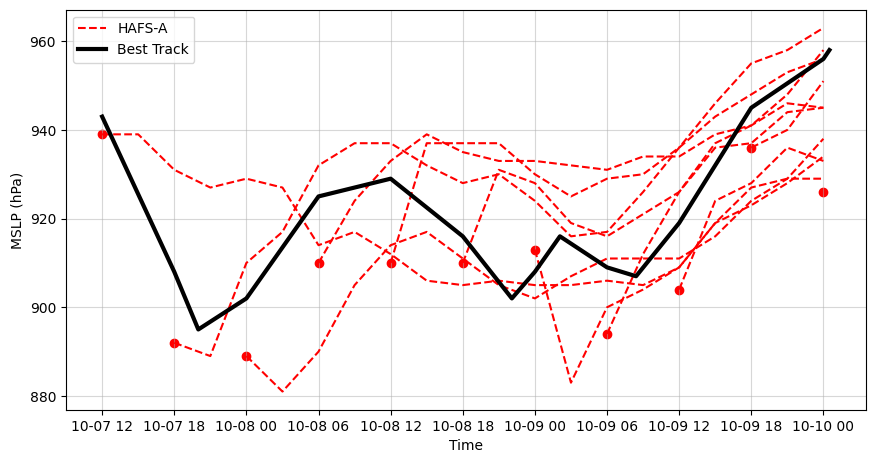

In [93]:
btDates = [dt.strptime(datetime, dateFormat) for datetime in tc.time]
runDates = [dt.strptime(run, runFormat) for run in stormMSLP.keys()]
stormStartMSLPs = [list(stormMSLP[key].values())[0] for key in stormMSLP.keys()]

mslpFig = plt.figure(figsize=(10, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormMSLP.keys():
  if run == list(stormMSLP.keys())[0]: mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), label="HAFS-A", linestyle="--", color="red")
  else: mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), linestyle="--", color="red")

#Add points to indicate the start of a run
mslpAx.scatter(runDates, stormStartMSLPs, color="red")

mslpAx.plot(btDates, tc.mslp, label="Best Track", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend()

mslpFig.savefig(filepath + "/mslp_allRuns.png")

# Model track error
Quantify and maybe plot. Be careful if there are multiple min MSLP pixels.